# Priority Sort Task Plots

In order to run this on Colab, uncomment the following lines and run them into a cell:

```bash
%%bash
cd ~
git clone https://github.com/geektoni/pytorch-ntm
cd pytorch-ntm
git checkout GPU_support
pip install -r requirements.txt
pwd
```

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))

batch_num = 100000
seed = 42 #10
seq_len = 16 #4
seq_num_bits = 10 #1

%matplotlib inline

In [81]:
files = glob("./checkpoints/results_100000.json")
files

['./checkpoints/results_100000.json']

In [82]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print(len(history))
print("Training history (seed x metric x sequence) =", training[: ,:, :-1].shape)
training = training[: ,:, :-1]

1
Training history (seed x metric x sequence) = (1, 3, 100000)


In [83]:
# Average every dv values across each (seed, metric)
dv = 1000
print(training.size)
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

300000
(1, 3, 100)


In [84]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 100)
(3, 100)


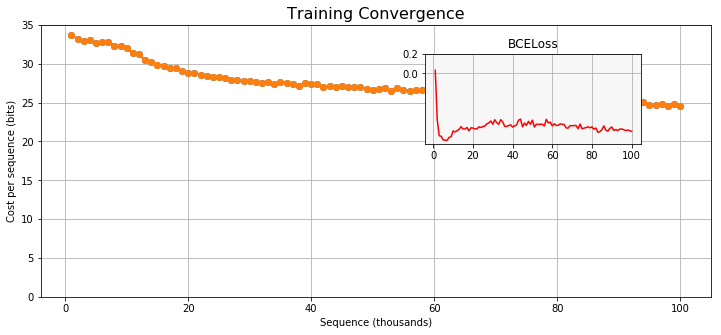

In [85]:
fig = plt.figure(figsize=(12, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+5, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

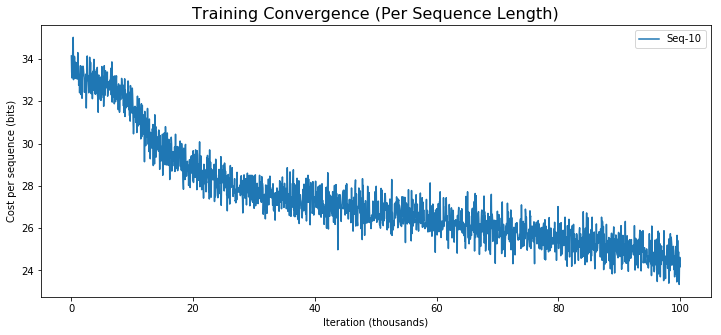

In [86]:
loss = history[0]['loss']
cost = history[0]['cost']
seq_lengths = history[0]['seq_lengths']

unique_sls = set(seq_lengths)
all_metric = list(zip(range(1, batch_num+1), seq_lengths, loss, cost))

fig = plt.figure(figsize=(12, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Iteration (thousands)')
plt.title('Training Convergence (Per Sequence Length)', fontsize=16)

for sl in unique_sls:
    sl_metrics = [i for i in all_metric if i[1] == sl]

    x = [i[0] for i in sl_metrics]
    y = [i[3] for i in sl_metrics]
    
    num_pts = len(x) // 50
    total_pts = num_pts * 50
    
    x_mean = [i.mean()/1000 for i in np.split(np.array(x)[:total_pts], num_pts)]
    y_mean = [i.mean() for i in np.split(np.array(y)[:total_pts], num_pts)]
    
    plt.plot(x_mean, y_mean, label='Seq-{}'.format(sl))

#plt.yticks(np.arange(0, 5, 5))
plt.legend(loc=0)
plt.show()

# Evaluate

In [87]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io
from utils import generate_data
#from generate_data import generate_data
#from train import evaluate

In [88]:
#from tasks.prioritysort import PrioritySortTaskModelTraining, PrioritySortTaskParams
#params = PrioritySortTaskParams()
#params.sequence_width=seq_num_bits
#params.sequence_max_length=seq_len
#model = PrioritySortTaskModelTraining(params)

In [89]:
#model.net.load_state_dict(torch.load("./../results/priority-sort/priority-sort-task-{}-8-16-batch-{}.model".format(seed, batch_num)))

In [109]:
from dnc.dnc import DNC

x, y = generate_data(1, 10, 10, 1)

rnn = DNC(input_size=10,
        hidden_size=100,
        rnn_type="lstm",
        num_layers=1,
        num_hidden_layers=2,
        dropout=0,
        nr_cells=128,
        cell_size=20,
        read_heads=5,
        gpu_id=-1,
        debug=False,
        batch_first=True,
        independent_linears=False)
rnn.load_state_dict(torch.load("./checkpoints/step_300000.pth"))

(chx, mhx, rv) = (None, None, None)
output, (chx, mhx, rv) = rnn(x, (None, mhx, None), reset_experience=True, pass_through_memory=True)
y_out = output

In [110]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(1)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[0, i, j].item()
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(im1, im2, pad=8):
    assert im1.size == im2.size
    w, h = im1.size

    width = w
    height = h * 2 + pad

    im = Image.new('L', (width, height), color=255)
    im.paste(im1, (0, 0))
    im.paste(im2, (0, h+pad))
    return im

### We then show the difference between the target sequence (list of binary segment orderd by priority) and the output sequence generated by the NTM

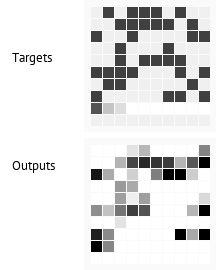

In [111]:
def make_eval_plot(y, y_out, u=12):
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    im = im_vconcat(im_y, im_y_out, u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
    font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Targets", font=font)
    draw.text((u,13*u), "Outputs", font=font)
    
    return im2

# TODO: remove slicing of y_out when new data are
# supplied (since we changed the generate_data procedure).
im3 = make_eval_plot(y, y_out[:, : 10:])
IPythonImage(im_to_png_bytes(im3))

![](../images/priority-sort-train-80-fast.gif "segment")